In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import time
import math
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import *
from matplotlib.colors import LinearSegmentedColormap
import plotly.graph_objects as go

!pwd
!python --version
import metnum

CIUDAD='Cancún'
PROVINCIA='Quintana Roo'
CENTER = np.array([21.142350, -86.804289])
LAT1 = 21
LAT2 = 22
LNG1 = -87
LNG2 = -86
shapefile = 'ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp'
shapefile_q_r = 'nyu_2451_37028/qroo_frente_de_manzana.shp'

def mejora(row):
    return ((100*row['rmsle'])/row['rmsle_viejo']) -100

def clean_dataframe(df, provincia, ciudad, lat1, lat2, lng1, lng2):
    df_provincia = df.copy(deep=True)

    df_provincia = df_provincia[df_provincia['provincia'] == provincia ]
    df_provincia = df_provincia[df_provincia['ciudad'].notna()]

    df_ciudad = df_provincia.copy(deep=True)
    df_ciudad = df_ciudad[df_ciudad['ciudad'] == ciudad]
    df_ciudad = df_ciudad[df_ciudad['lat'].notna()]
    df_ciudad = df_ciudad[df_ciudad['lng'].notna()]
    df_ciudad = df_ciudad[df_ciudad['lat'].between(lat1,lat2)]
    df_ciudad = df_ciudad[df_ciudad['lng'].between(lng1,lng2)]
    return df_ciudad

def add_new_feature(df_old):
    df = df_old.copy(deep=True)
    center = CENTER
    df['radio'] = df.apply(lambda row: add_radio(row,center),axis=1)
    return df

#Al tratarse de puntos distribuidos en una zona relativamente pequeña, 
#usamos la distancia euclidea como buena aproximación a la distancia 
#real entre dos puntos sobre el globo terraqueo.
def add_radio(row, center):
    point = np.array([row['lat'],row['lng']])
    return np.linalg.norm(point-center)

def find_propiedades(df):
    propiedades =[]
    for propiedad in df['tipodepropiedad'].unique():
        if(len(df[df['tipodepropiedad']==propiedad])>100):
            propiedades.append(propiedad)
    return propiedades

def calculate_metrics(variable_to_predict, df_old):
    df = df_old.copy(deep=True)
    df = df[df['prediction'].notna()]
    df = df[df['prediction']>-1]
    return (math.sqrt(mean_squared_error(df[variable_to_predict], df['prediction'])),
            math.sqrt(mean_squared_log_error(df[variable_to_predict]+1, df['prediction']+1)))

def experiment(percentage_of_training_cases,
         variable_to_predict,
         variables_to_study,
         seed, 
         df_old,
         data):
    df = df_old.copy(deep=True)

    t0 = time.time()

    df = df[0:].sample(frac=1, random_state=seed)
    
    #cleanup
    df = df[df[variable_to_predict].notna()]
    for var in variables_to_study:
        df = df[df[var].notna()]
    
    TOTAL_TRAIN_CASES = int(percentage_of_training_cases*len(df))
    
    df_prediction = df[TOTAL_TRAIN_CASES:].copy(deep=True)

    df = df[:TOTAL_TRAIN_CASES]
    
    x_train, y_train = df[variables_to_study].values, df[variable_to_predict].values
    x_predict, y_predict = df_prediction[variables_to_study].values, df_prediction[variable_to_predict].values
    
    x_train = x_train.reshape(len(x_train),len(variables_to_study))
    y_train = y_train.reshape(len(y_train),1)
    x_predict = x_predict.reshape(len(x_predict),len(variables_to_study))
    y_predict = y_predict.reshape(len(y_predict),1)

    linear_regressor = metnum.LinearRegression()
    linear_regressor.fit(x_train, y_train)
    df_prediction['prediction'] = linear_regressor.predict(x_predict)

    t1 = time.time()
    total_time = (t1-t0)
    
    rmse, rmsle = calculate_metrics(variable_to_predict, df_prediction)
    data['rmse'].append(rmse)
    data['rmsle'].append(rmsle)
    data['percentage_of_train_cases'].append(percentage_of_training_cases)
    data['time'].append(total_time)
    
    if(len(variables_to_study)==1):
        sns.scatterplot(data=df_prediction, x=variables_to_study[0], y=variable_to_predict)
        sns.lineplot(data=df_prediction, x=variables_to_study[0], y='prediction', color='red')
    elif(len(variables_to_study)==2):
        fig = plt.figure(figsize=(20,10))
        ax = fig.gca(projection='3d')
        ax.set_xlabel('X', fontsize=15, rotation=150)
        ax.set_ylabel('Y')
        ax.set_zlabel(r'Z', fontsize=15)
        ax.scatter(df_prediction[variables_to_study[0]],
                   df_prediction[variables_to_study[1]],
                   df_prediction['prediction'], c='skyblue', s=60)
        ax.plot_trisurf(df_prediction[variables_to_study[0]], 
                        df_prediction[variables_to_study[1]], 
                        df_prediction['prediction'], cmap=plt.cm.viridis, linewidth=0.2)
        plt.show()
    return df_prediction
    
df = pd.read_csv('../data/train.csv')

df_cancun = clean_dataframe(df, PROVINCIA, CIUDAD, LAT1, LAT2, LNG1, LNG2)

df_cancun = add_new_feature(df_cancun)

propiedades = find_propiedades(df_cancun)

folder='./experimento_cancun_{}'.format(int(time.time()))
os.mkdir(folder)

df_cancun[['lat','lng','precio']].to_csv(folder+'/test.csv', 
                                 encoding='utf-8', index=False)

##Experimentacion
rmsle_averages =[]
i=10
for propiedad in propiedades:
    i = i+10
    d = {'rmse' : [], 'rmsle' : [], 'percentage_of_train_cases' : [], 'time' : []}
    df_propiedad = df_cancun[df_cancun['tipodepropiedad']==propiedad]

    for j in np.arange(1,31,1):
        df_prediction = experiment(0.85, 'precio', ['metroscubiertos','radio'], j*i, 
                                   df_propiedad, d)
        df_prediction.to_csv(folder+'/prediction_'+propiedad+'_'+str(j)+'.csv', 
                                 encoding='utf-8', index=False)

    d_error = pd.DataFrame(data=d)    
    rmsle_averages.append([propiedad, d_error['rmsle'].mean()])
    d_error.to_csv(folder+'/error_metroscubiertos_y_radio_'+propiedad+'.csv', encoding='utf-8', index=False)
    
df_rmsle_average = pd.DataFrame(rmsle_averages, columns = ['propiedad','rmsle'])
df_rmsle_average.to_csv(folder+'/rmsle_metroscubiertos_y_radio_average.csv', encoding='utf-8', index=False)

/home/jazzer/Facultad/metodos_numericos_3/mt/tp3/notebooks
Python 3.6.10


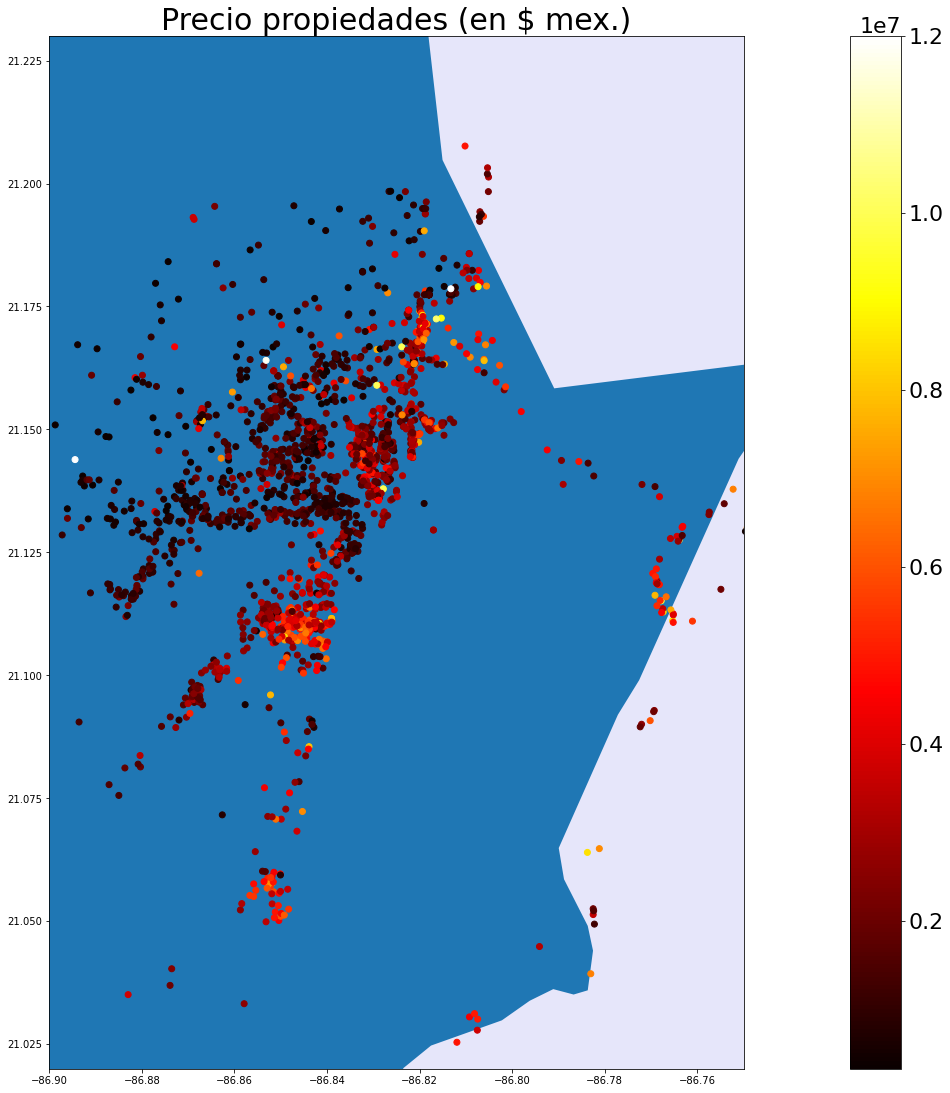

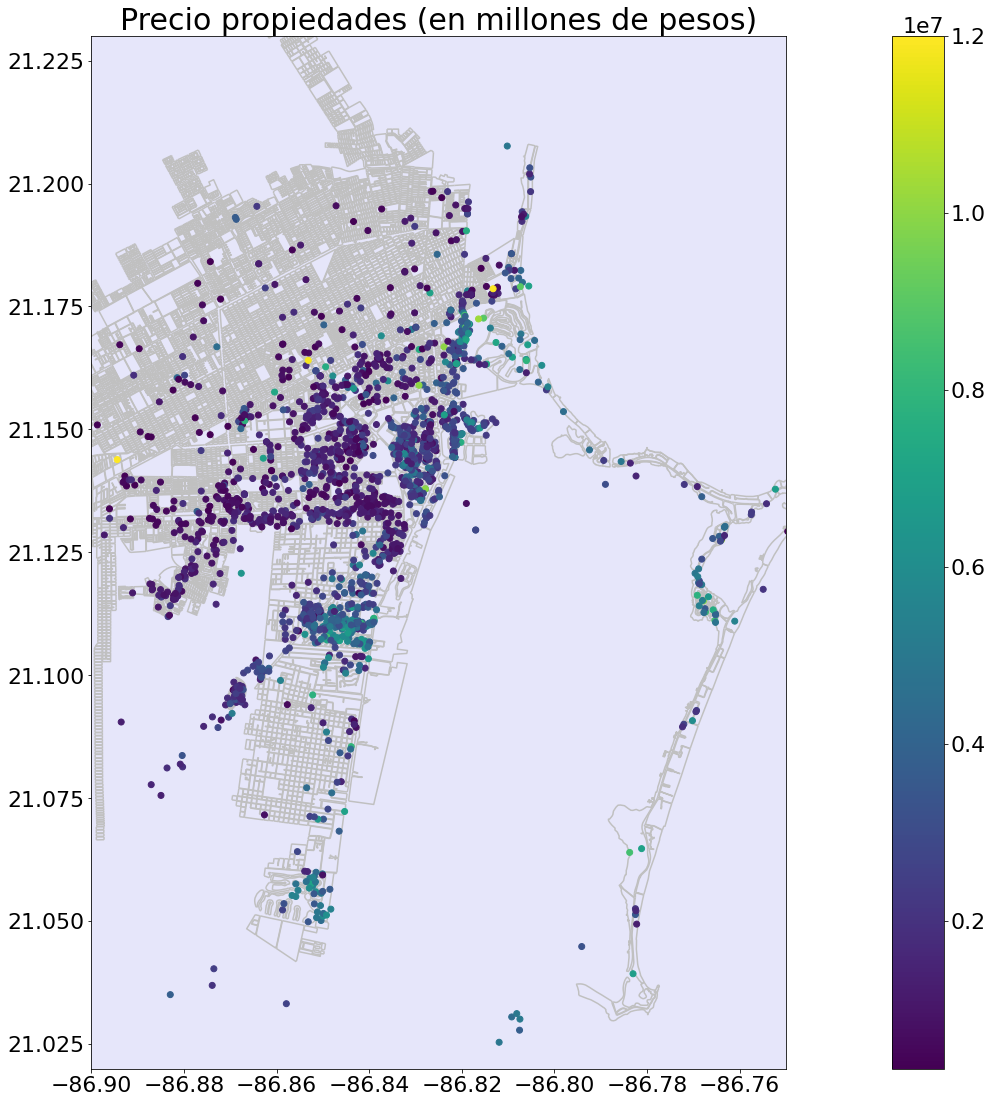

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import time
import math
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import *
from matplotlib.colors import LinearSegmentedColormap
import plotly.graph_objects as go

!pwd
!python --version
import metnum

CIUDAD='Cancún'
PROVINCIA='Quintana Roo'
CENTER = np.array([21.142350, -86.804289])
LAT1 = 21
LAT2 = 22
LNG1 = -87
LNG2 = -86
shapefile = 'ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp'
shapefile_q_r = 'nyu_2451_37028/qroo_frente_de_manzana.shp'

# folder='./cancun_metrostotales_{}'.format(int(time.time()))
# os.mkdir(folder)

# df_cancun[['lat','lng','precio']].to_csv(folder+'/test.csv', 
#                                  encoding='utf-8', index=False)

df_cancun = pd.read_csv('feature_engineering_cancun_1598749016'+'/test.csv')

# # Read shapefile using Geopandas
gdf = gpd.read_file(shapefile)[['name','admin','adm0_a3', 'geometry']]
gdf_q_r = gpd.read_file(shapefile_q_r)

# #Rename columns.
gdf.columns = ['province','country', 'country_code', 'geometry']
gdf = gdf[gdf['country'] == 'Mexico']
gdf = gdf[gdf['province'] == 'Quintana Roo']

# #Shape map
fig, ax = plt.subplots(1, 1)
ax.set_title("Precio propiedades (en $ mex.)", fontsize=30)
fig.set_size_inches(38, 19, forward=True)
ax.set_facecolor('lavender')
ax.set(xlim=(-86.9,-86.75), ylim=(21.02,21.23))
plt.rcParams.update({'font.size': 22})
gdf.plot(ax=ax, legend=True, 
            legend_kwds={'label': "Pesos mexicanos"})
    
sc = plt.scatter(y=df_cancun["lat"], x=df_cancun["lng"], c=df_cancun['precio'], 
                    alpha=1, cmap='hot')
plt.colorbar(sc)
plt.show()

# # street map
fig, ax = plt.subplots(1, 1)
ax.set_title("Precio propiedades (en millones de pesos)", fontsize=30)
ax.set(xlim=(-86.9,-86.75), ylim=(21.02,21.23))
ax.set_facecolor('lavender')
fig.set_size_inches(38, 19, forward=True)

cmap_q_r = LinearSegmentedColormap.from_list(
    'mycmap', [(0, 'silver'), (1, 'silver')])

# gdf_merged = gpd.overlay(gdf,gdf_q_r, how='union')

gdf_q_r.plot(ax=ax, cmap=cmap_q_r, legend=True, legend_kwds={'label': 
                                                            "Pesos mexicanos"})

sc = plt.scatter(y=df_cancun["lat"], x=df_cancun["lng"], c=df_cancun['precio'], 
                 zorder=3, alpha=1, cmap='viridis')
plt.colorbar(sc)
plt.show()
